# Grading Criteria
10% for coming up with your own problem definition based on a dataset <br>
10% for data preparation and cleaning to suit the problem of your choice<br>
20% for exploratory data analysis/visualization to gather relevant insights<br>
20% for the use of machine learning techniques to solve specific problem<br>
20% for the presentation of data-driven insights and the recommendations<br>
10% for the quality of your final team presentation and overall impressions<br>
10% for learning something new and doing something beyond this course<br>

## Background
Always wondered how the starting positions of F1 drivers are determined? This is where the qualifying session comes into play. Qualifying sessions determines the starting grid of the drivers for the actual race. It is split into three rounds, known as Q1, Q2, Q3. <br>

Q1: All cars participate in Q1, which lasts for 18 minutes. The aim is to set a fast enough time to advance to Q2. The slowest five or six drivers (depending on the season) are elminated at the end of Q1. <br>

Q2: The remaining cars from Q1 move on to Q2, which lasts for 15 minutes. Again, the aim is similiar to Q1, set a fast enough time to advance to Q3. The slowest five or six drovers are eliminated at the end of Q2. <br>

Q3: The top ten cars from Q2 advance into Q3, which lasts for 12 minutes. Here, the drivers compete for the pole position and the top spots on the grid. (Pole position refers to the most favourable position at the start of the race.) <br>

Here are some rules (not exhaustive) that have been updated in the recent years: <br>
1) **Grid Penalties:** If a driver receivesa grid penalty, they may be demoted a certiain number of places in the grid.  These penalities can be for various reasons, such as exceeding engine component limits, causing a collision in a previous race, or impeding another driver during qualifiying. <br>

2) **Tyres Rules:** In the recent years, tyre rules have also influenced qualifying strategies. Drivers must start the race on the same set of tyres they used in Q2, which adds a tactical element to tire management during qualifying.

## Problem Formulation:


**Problem Statement:** 
- With the dataset that we are given, we are trying to predict the drivers who will make it top 3 position in the Qualifying F1 Race.

**Input:** 
- Historical data from previous races, including track type, number of DRS zones, turns.
- Driver-specific information such as team, driver statistics (e.g. previous qualifying results, race results)

**Output:**
- Binary classification of whether each driver would make it to top 3 of the qualifiers.

In [119]:
# import necessary libraries
import math
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report
warnings.filterwarnings('ignore')

## Data preparation (10%)

The dataset given is split into the races that occured in that particular year. To make processing easier, we will be combining all these tabular data into 1 main dataset.

In [120]:
raceResults_df = pd.DataFrame()
years = ['2021','2022','2023']
for y in years:
    temp_df = pd.read_csv(f"./Race_Results/formula1_{y}season_raceResults.csv")
    temp_df['Year'] = y # we create a new column Year so that we can use it to extract relevant data of the track on that particular year
    raceResults_df = pd.concat([raceResults_df, temp_df])
raceResults_df.head(5)

,Track,Position,No,Driver,Team,Starting Grid,Laps,Time/Retired,Points,+1 Pt,Fastest Lap,Year,Set Fastest Lap,Fastest Lap Time
0,Bahrain,1,44,Lewis Hamilton,Mercedes,2.0,56,1:32:03.897,25.0,No,1:34.015,2021,NaN,NaN
1,Bahrain,2,33,Max Verstappen,Red Bull Racing Honda,1.0,56,+0.745,18.0,No,1:33.228,2021,NaN,NaN
2,Bahrain,3,77,Valtteri Bottas,Mercedes,3.0,56,+37.383,16.0,Yes,1:32.090,2021,NaN,NaN
3,Bahrain,4,4,Lando Norris,McLaren Mercedes,7.0,56,+46.466,12.0,No,1:34.396,2021,NaN,NaN
4,Bahrain,5,11,Sergio Perez,Red Bull Racing Honda,11.0,56,+52.047,10.0,No,1:33.970,2021,NaN,NaN


The 14 columns we have as of now seems to not be comprehensive enough for us to explore/ gain any insights in regards to our problem. This is because we have a couple of columns that are not very insightful, e.g. 'No.', 'Points', 'Fastest Lap', '+1 Pt'. In this case, we shall explore another set of data that could possibly help us make more informed predictions. Afterall, predicting such race results is a rather complex task since it can be affected by numerous factors.

In [121]:
# Import the other datasets
seasonCalender_df = pd.DataFrame()
years = ['2020','2021','2022','2023']
for y in years:
    temp_df = pd.read_csv(f"./Season_Calenders/formula1_{y}season_calendar.csv")
    temp_df['Year'] = y # we create a new column Year so that we can use it to extract relevant data of the track on that particular year
    seasonCalender_df = pd.concat([seasonCalender_df, temp_df])
seasonCalender_df.head(5)

,Round,Country,City,Circuit Name,GP Name,Race Date,First GP,Number of Laps,Circuit Length(km),Race Distance(km),Lap Record,Record Owner,Record Year,Turns,DRS Zones,Year
0,1,Austria,Spielberg,Red Bull Ring,Austria,5 Jul 2020,1970,71,4.318,306.452,1:05.619,Carlos Sainz,2020,10,3,2020
1,2,Austria,Spielberg,Red Bull Ring,Styria,12 Jul 2020,1970,71,4.318,306.452,1:05.619,Carlos Sainz,2020,10,3,2020
2,3,Hungary,Budapest,Hungaroring,Hungary,19 Jul 2020,1986,70,4.381,306.630,1:17.103,Max Verstappen,2019,14,2,2020
3,4,Great Britain,Silverstone,Silverstone Circuit,Great Britain,2 Aug 2020,1950,52,5.891,306.198,1:27.097,Max Verstappen,2020,18,2,2020
4,5,Great Britain,Silverstone,Sliverstone Circuit,70th Anniversary,9 Aug 2020,1950,52,5.891,306.198,1:27.097,Max Verstappen,2020,18,2,2020


In [122]:
features_to_extract = ['DRS Zones', 'Turns', 'Circuit Length(km)']
for index, row in raceResults_df.iterrows():
    track = row['Track']
    year = row['Year']
    matching_race = seasonCalender_df[(seasonCalender_df['Country'] == track) & (seasonCalender_df['Year'] == year)]
    if not matching_race.empty:
        for feature in features_to_extract:
            f = matching_race[feature].iloc[0]
            raceResults_df.at[index, feature] = f
raceResults_df.head(5)

,Track,Position,No,Driver,Team,Starting Grid,Laps,Time/Retired,Points,+1 Pt,Fastest Lap,Year,Set Fastest Lap,Fastest Lap Time,DRS Zones,Turns,Circuit Length(km)
0,Bahrain,1,44,Lewis Hamilton,Mercedes,2.0,56,1:32:03.897,25.0,No,1:34.015,2021,NaN,NaN,3.0,15.0,5.412
1,Bahrain,2,33,Max Verstappen,Red Bull Racing Honda,1.0,56,+0.745,18.0,No,1:33.228,2021,NaN,NaN,3.0,15.0,5.412
2,Bahrain,3,77,Valtteri Bottas,Mercedes,3.0,56,+37.383,16.0,Yes,1:32.090,2021,NaN,NaN,3.0,15.0,5.412
3,Bahrain,4,4,Lando Norris,McLaren Mercedes,7.0,56,+46.466,12.0,No,1:34.396,2021,NaN,NaN,3.0,15.0,5.412
4,Bahrain,5,11,Sergio Perez,Red Bull Racing Honda,11.0,56,+52.047,10.0,No,1:33.970,2021,NaN,NaN,3.0,15.0,5.412


Nice! Now we have a collated dataframe to work with. Next step would be to extract the relevant features we wish to use in our model. The descriptions of the variables we have chosen is as of below: <br>
## Race Data Description 🏁🏎️💨

- **Driver:** Name of the driver
- **Team:** Name of the team the driver is in
- **Track:** The track in which the race was held on
- **Fastest Lap Time:** The shortest time taken for the driver to complete 1 lap
- **DRS Zones:** Drag Reduction System Zones, which are zones that allow the driver to open up the rear wings flap to increase speed for overtaking
- **Circuit Length (km):** The length of the circuit in kilometers
- **Turns:** Number of turns that are in 1 lap of the circuit

---

In [123]:
features = ['Driver', 'Team', 'Track', 'Fastest Lap Time', 'DRS Zones', 'Circuit Length(km)', 'Turns', 'Starting Grid']
cleaned_df = raceResults_df[features]
cleaned_df.head(5)

,Driver,Team,Track,Fastest Lap Time,DRS Zones,Circuit Length(km),Turns,Starting Grid
0,Lewis Hamilton,Mercedes,Bahrain,NaN,3.0,5.412,15.0,2.0
1,Max Verstappen,Red Bull Racing Honda,Bahrain,NaN,3.0,5.412,15.0,1.0
2,Valtteri Bottas,Mercedes,Bahrain,NaN,3.0,5.412,15.0,3.0
3,Lando Norris,McLaren Mercedes,Bahrain,NaN,3.0,5.412,15.0,7.0
4,Sergio Perez,Red Bull Racing Honda,Bahrain,NaN,3.0,5.412,15.0,11.0


In [124]:
cleaned_df['Fastest Lap Time'].isna().sum()

893

As we can tell, the fastest lap time seems to have quite a handful of missing values. Using a mean/median approach to compute the fastest lap timing does seem not very fitting, especially since each racing track has their own unique characteristics. In this case, we will attempt to use a linear regression model to predict the missing fastest lap timings.

In [125]:
from datetime import datetime, timedelta

def time_string_to_float(time_str):
    if pd.isna(time_str): # skip the ones that are Nan.
        return np.nan
    time_delta = pd.to_timedelta('00:' + time_str) # '00' to match with our data
    time_seconds = time_delta.total_seconds()
    return time_seconds

cleaned_df['Fastest Lap Time'] = cleaned_df['Fastest Lap Time'].apply(lambda x: time_string_to_float(x))
cleaned_df.head(5)

,Driver,Team,Track,Fastest Lap Time,DRS Zones,Circuit Length(km),Turns,Starting Grid
0,Lewis Hamilton,Mercedes,Bahrain,NaN,3.0,5.412,15.0,2.0
1,Max Verstappen,Red Bull Racing Honda,Bahrain,NaN,3.0,5.412,15.0,1.0
2,Valtteri Bottas,Mercedes,Bahrain,NaN,3.0,5.412,15.0,3.0
3,Lando Norris,McLaren Mercedes,Bahrain,NaN,3.0,5.412,15.0,7.0
4,Sergio Perez,Red Bull Racing Honda,Bahrain,NaN,3.0,5.412,15.0,11.0


In [126]:
cleaned_df[cleaned_df['Starting Grid'].isnull()] # we will remove this row containing a NaN Starting Grid.

,Driver,Team,Track,Fastest Lap Time,DRS Zones,Circuit Length(km),Turns,Starting Grid
189,Yuki Tsunoda,AlphaTauri Honda,Great Britain,NaN,2.0,5.891,18.0,NaN


In [127]:
cleaned_df = cleaned_df[~cleaned_df['Starting Grid'].isnull()]

In [128]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Separate data into subsets with complete and missing "Fastest Lap Time" values
complete_data = cleaned_df.dropna(subset=['Fastest Lap Time'])
missing_data = cleaned_df[cleaned_df['Fastest Lap Time'].isna()]

# Choose predictor variables
predictor_cols = ['DRS Zones', 'Circuit Length(km)', 'Turns', 'Starting Grid']

# Create regression model
model = LinearRegression()

# Train the model
model.fit(complete_data[predictor_cols], complete_data['Fastest Lap Time'])

# Predict missing values
missing_data['Fastest Lap Time'] = model.predict(missing_data[predictor_cols])

# Apply imputation to the entire dataset
cleaned_df = pd.concat([complete_data, missing_data], axis=0)
cleaned_df

,Driver,Team,Track,Fastest Lap Time,DRS Zones,Circuit Length(km),Turns,Starting Grid
0,Max Verstappen,Red Bull Racing Honda RBPT,Bahrain,96.236000,3.0,5.412,15.0,1.0
1,Sergio Perez,Red Bull Racing Honda RBPT,Bahrain,96.344000,3.0,5.412,15.0,2.0
2,Fernando Alonso,Aston Martin Aramco Mercedes,Bahrain,96.156000,3.0,5.412,15.0,5.0
3,Carlos Sainz,Ferrari,Bahrain,97.130000,3.0,5.412,15.0,4.0
4,Lewis Hamilton,Mercedes,Bahrain,96.546000,3.0,5.412,15.0,7.0
...,...,...,...,...,...,...,...,...
339,Carlos Sainz,Ferrari,Qatar,92.419466,1.0,5.419,16.0,12.0
379,Sergio Perez,Red Bull Racing Honda RBPT,Mexico,82.429136,3.0,4.304,17.0,5.0
397,Kevin Magnussen,Haas Ferrari,Brazil,82.325308,2.0,4.309,15.0,12.0
398,Alexander Albon,Williams Mercedes,Brazil,82.393620,2.0,4.309,15.0,13.0


## Exploratory Data Analysis (20%)

### Uni-variate Exploration

Now, let us build some intuition with the data we have. <br>
First, let us take a look at the number of times each driver made it into the top 3 for the actual race.

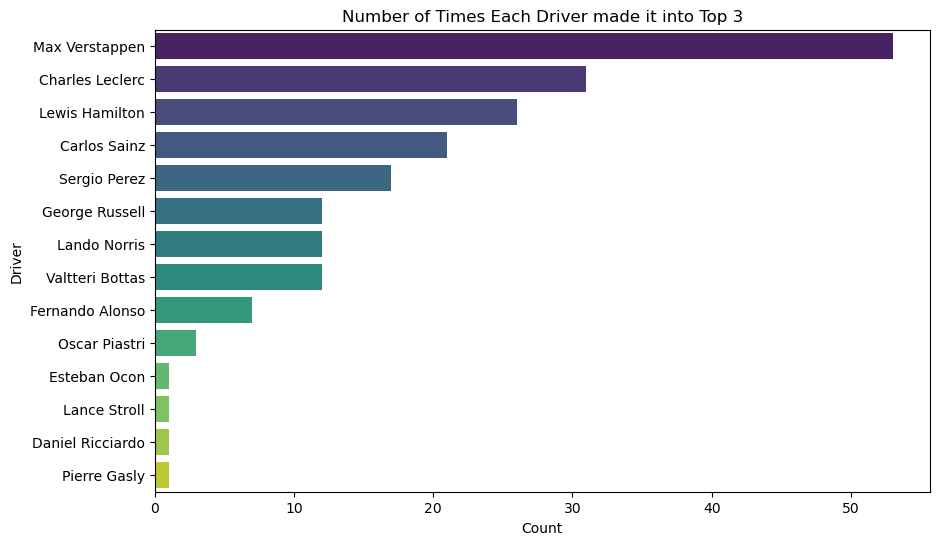

In [129]:
top3_df = cleaned_df[cleaned_df['Starting Grid']<=3]

plt.figure(figsize=(10,6))
sb.countplot(top3_df, y='Driver', order=top3_df['Driver'].value_counts().index, palette='viridis')
plt.title('Number of Times Each Driver made it into Top 3')
plt.xlabel('Count')
plt.ylabel('Driver')
plt.show()

Interesting, seems like Max Verstappen has been dominating the F1 qualifying rounds for the past 3 years, making it to the top 3 grid positions much more frequently than the other drivers. Charles Leclerc and Lewis Hamilton has been also making it to the top 3 grid positions rather frequently.

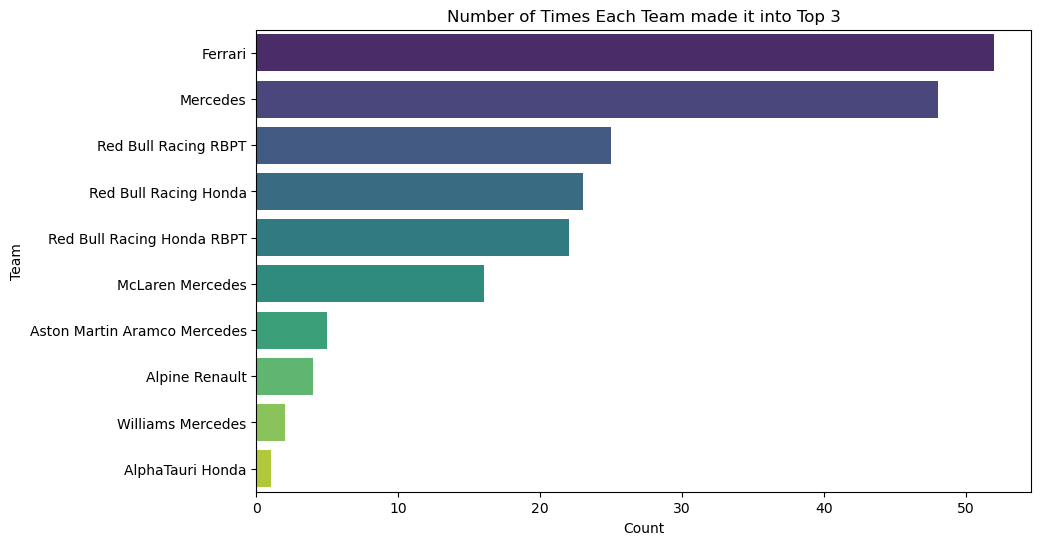

In [130]:
top3_df = cleaned_df[cleaned_df['Starting Grid']<=3]

plt.figure(figsize=(10,6))
sb.countplot(top3_df, y='Team', order=top3_df['Team'].value_counts().index, palette='viridis')
plt.title('Number of Times Each Team made it into Top 3')
plt.xlabel('Count')
plt.ylabel('Team')
plt.show()

Among the teams that achieved a top 3 grid position, Ferrari and Mercedes appear to be the most dominant, with Red Bull Racing RBPT following closely behind.

<function matplotlib.pyplot.show(close=None, block=None)>

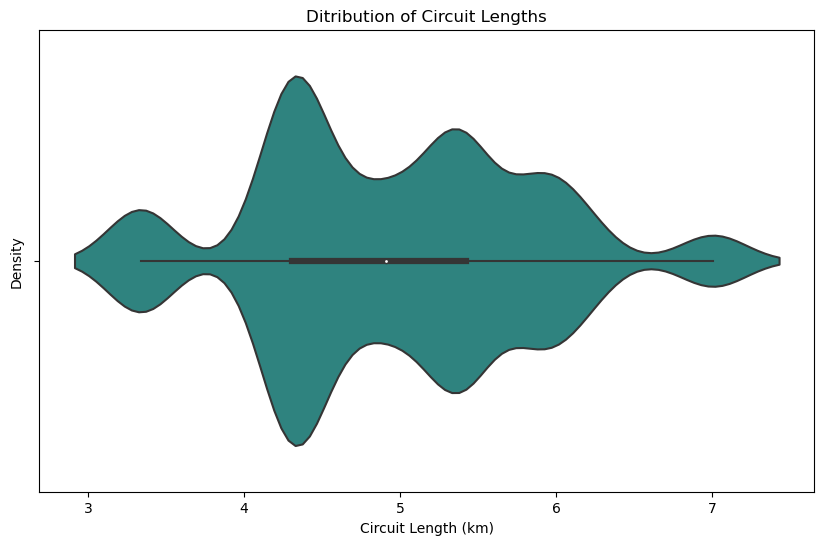

In [131]:
plt.figure(figsize=(10,6))
sb.violinplot(cleaned_df, x='Circuit Length(km)', palette='viridis')
plt.title('Ditribution of Circuit Lengths')
plt.xlabel('Circuit Length (km)')
plt.ylabel('Density')
plt.show

The graph above shows a concentration around 5km, indicating that this is a common length for Formula 1 race circuits. This could be due to standardization of race lengths or constraints related to circuit construction and safety requirements.

<function matplotlib.pyplot.show(close=None, block=None)>

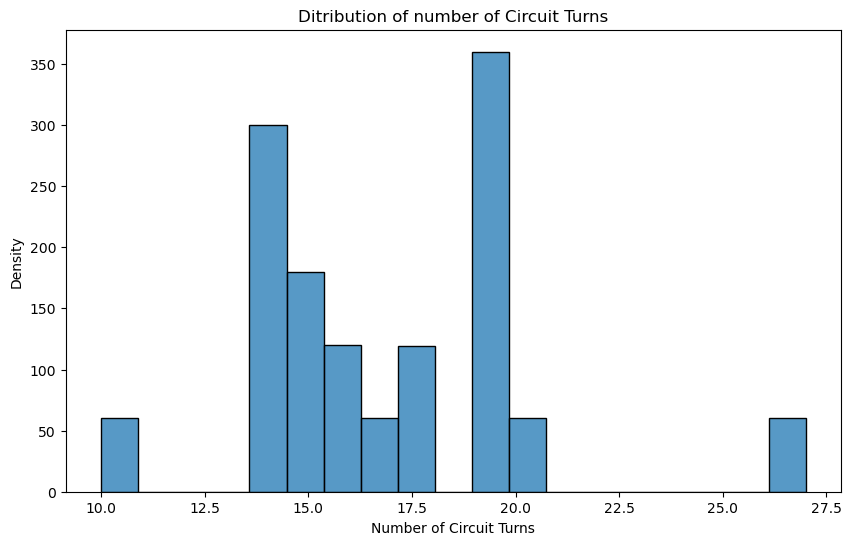

In [132]:
plt.figure(figsize=(10,6))
sb.histplot(cleaned_df, x='Turns')
plt.title('Ditribution of number of Circuit Turns')
plt.xlabel('Number of Circuit Turns')
plt.ylabel('Density')
plt.show

The common pattern that can be observed is that the number of turns in Formula 1 circuits commonly falls around 15 to 20. This pattern could be reflecting a balance between maintaining race complexity and ensuring driver safety that the same time.

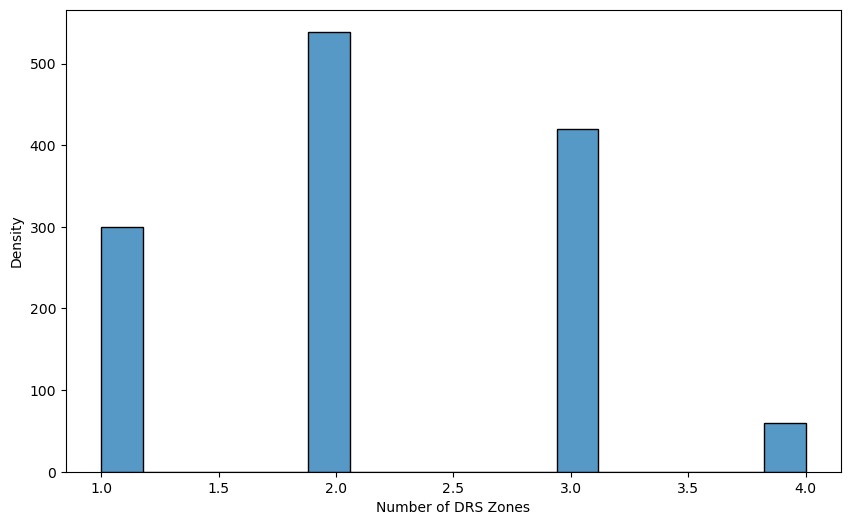

In [133]:
plt.figure(figsize=(10,6))
sb.histplot(cleaned_df, x='DRS Zones')
plt.xlabel('Number of DRS Zones')
plt.ylabel('Density')
plt.show()

The spread of DRS Zones does not seem very big, with most of the tracks with 2-3 DRS Zones for the race track.

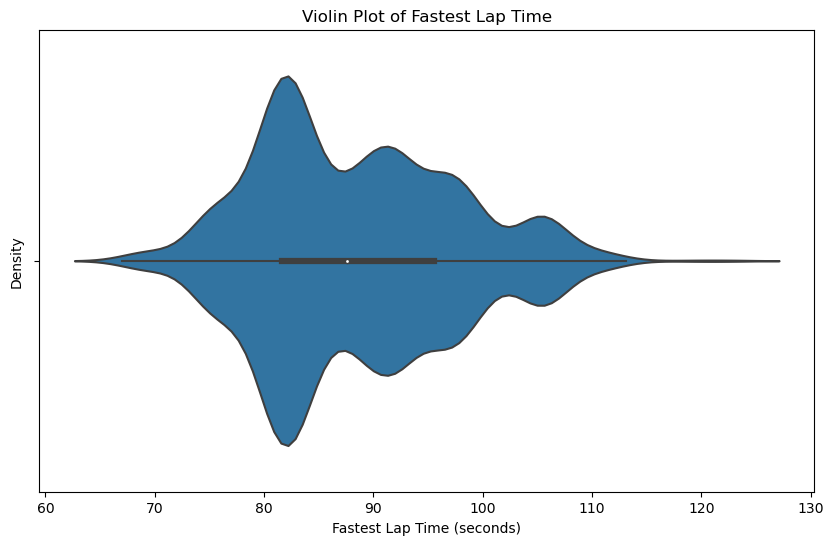

In [134]:
plt.figure(figsize=(10, 6))
sb.violinplot(x=cleaned_df['Fastest Lap Time'])
plt.title('Violin Plot of Fastest Lap Time')
plt.xlabel('Fastest Lap Time (seconds)')
plt.ylabel('Density')
plt.show()

The violin plot of fastest lap times for Formula 1 drivers reveals an intriguing distribution. Most drivers clock in around 90 to 100 seconds, while outliers push the limits below 80 or above 110 seconds.

As we transition from univariate exploratory data analysis (EDA) to bivariate EDA, we are now ready to explore the relationships between pairs of variables in our dataset. While univariate EDA provided valuable insights into individual variables, bivariate EDA allows us to uncover connections, dependencies, and interactions between two variables. By examining the correlations, and patterns between variables, we can gain a deeper understanding of how they influence each other and uncover hidden insights that may not be apparent when analyzing variables in isolation. Let's delve into our data further and explore the rich relationships between variables through bivariate analysis.

### Bi-variate analysis

Correlation between Circuit Length and Fastest Lap Time: 0.7911121228252681


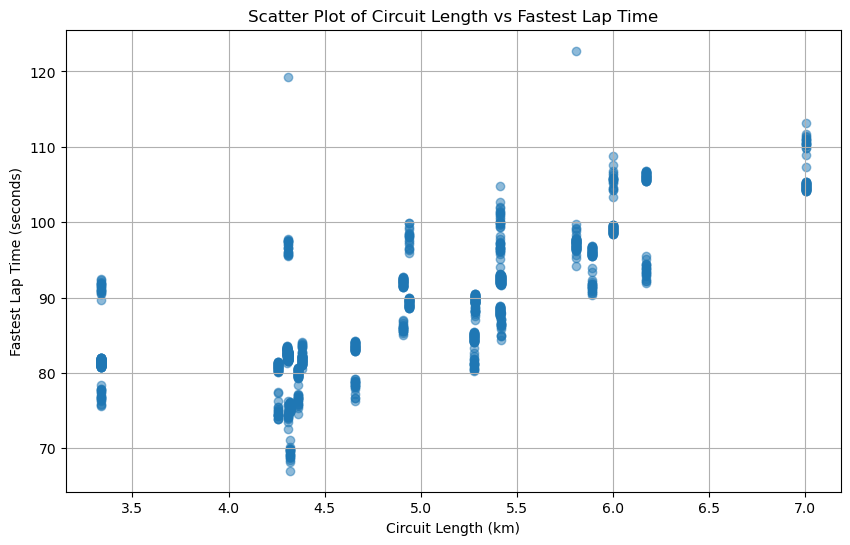

In [135]:
correlation = cleaned_df['Circuit Length(km)'].corr(cleaned_df['Fastest Lap Time'])
print("Correlation between Circuit Length and Fastest Lap Time:", correlation)
plt.figure(figsize=(10, 6))
plt.scatter(cleaned_df['Circuit Length(km)'], cleaned_df['Fastest Lap Time'], alpha=0.5)
plt.title('Scatter Plot of Circuit Length vs Fastest Lap Time')
plt.xlabel('Circuit Length (km)')
plt.ylabel('Fastest Lap Time (seconds)')
plt.grid(True)
plt.show()

This graph aligns with our expectations, as a longer circuit length typically results in a longer fastest lap time. Therefore, there is a positive correlation between circuit length and fastest lap time. This correlation suggests that as the length of the circuit increases, drivers generally take longer to complete a lap due to the increased distance they need to cover.

Correlation between Number of Turns and Fastest Lap Time: 0.6732531395648562


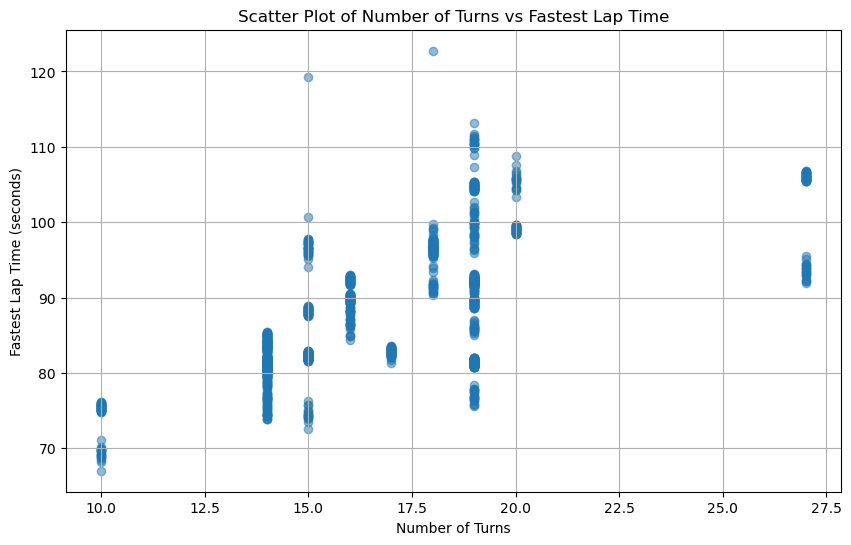

In [136]:
correlation = cleaned_df['Turns'].corr(cleaned_df['Fastest Lap Time'])
print("Correlation between Number of Turns and Fastest Lap Time:", correlation)
plt.figure(figsize=(10, 6))
plt.scatter(cleaned_df['Turns'], cleaned_df['Fastest Lap Time'], alpha=0.5)
plt.title('Scatter Plot of Number of Turns vs Fastest Lap Time')
plt.xlabel('Number of Turns')
plt.ylabel('Fastest Lap Time (seconds)')
plt.grid(True)
plt.show()

From the scatter plot and the coefficient calculated, we can see that Number of Turns and Fastest Lap Time has a positive correlation with one another. With a larger number of turns on the circuit, there are more occurrences where the driver has to slow down to negotiate the turns. As a result, this can lead to an increase in the fastest lap time. This is because each turn requires the driver to reduce speed before accelerating again, thereby potentially slowing down the overall lap time.

## Machine Learning (20%)

Now that we have gained valuable insights into our dataset through Exploratory Data Analysis (EDA), it's time to leverage machine learning techniques to build predictive models. By applying sophisticated algorithms to our data, we aim to uncover underlying patterns and relationships that will enable us to make accurate predictions and informed decisions. In this next phase, we will preprocess our data, select appropriate features, and train machine learning models to predict the drivers who will emerge as top 3 in qualifying F1 races, empowering us to extract actionable insights and drive meaningful outcomes.

We will now first start off by trying out using a random forest model. We have chosen to explore the random forest model due to its versatility, robustness, and ability to handle complex datasets effectively. Random forests are an ensemble learning technique that combines multiple decision trees to deliver reliable predictions while mitigating overfitting. By leveraging the collective wisdom of multiple trees, random forests excel in capturing intricate relationships within the data, making them particularly suitable for our case, which is a predictive modeling task. Through this exploration, we aim to harness the power of random forests to extract actionable insights and achieve superior predictive accuracy our my analysis.

In [137]:
X_features = ['Driver', 'Team', 'Track','DRS Zones', 'Circuit Length(km)', 'Turns', 'Fastest Lap Time']
# I removed the Fastest Laps for now

X = cleaned_df[X_features]
y = cleaned_df['Starting Grid']
y.fillna(20, inplace=True)
y_binary = (y <= 3).astype(int)
print("Number of data points for each class (Train Set):")
print(y_binary.value_counts())
X_encoded = pd.get_dummies(X, columns = ['Driver', 'Team', 'Track'])

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_binary, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators = 100, random_state=42)
model.fit(X_train, y_train)

proba_predictions = model.predict_proba(X_test)
top3_probabilities = proba_predictions[:, 1] # To extract the probabilities for drivers making to top 3 positions.

threshold = 0.8  # threshold probability

predicted_top3 = (top3_probabilities > threshold).astype(int)  # Classify instances based on the threshold

# Compute accuracy
accuracy = accuracy_score(y_test, predicted_top3)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, predicted_top3))

Number of data points for each class (Train Set):
0    1121
1     198
Name: Starting Grid, dtype: int64
Accuracy: 0.8611111111111112
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       334
           1       0.82      0.15      0.25        62

    accuracy                           0.86       396
   macro avg       0.84      0.57      0.59       396
weighted avg       0.86      0.86      0.82       396



Let us take a look closely at our classificaiton metrics. <br>

**Accuracy:** Accuracy measures the overall correctness of our model. 0.861 accuracy indicates that our model correctly predicted 87.1% of the instances.<br>

**Precision:** Precision refers to the ratio of correctly predicted positive observations to the total positives.
    <li> Precision for class 0 (not in top 3) is 0.86. This means the model is correct 86% of the time when predicting the drivers that are not in top 3. <br>
    <li> Precision for class 1 (in top 3) is 0.82. This means the model is correct 82% of the time when predicting the drivers that are in top 3.<br>
        
**Recall:** Recall is the ratio of correctly predicted positive observations to all the observations in actual class.<br>
        <li> Recall for class 0: 0.99. This means that the model corrrectly predicted most of the instances where the driver is not in the top 3 positions. <br>
        <li> Recall for class 1: 0.15. This suggests that the model has missed identifying many instances of the drivers in top 3. <br>

            
**F1-Score:** The F1-score refers to the harmonic mean of precision and recall.
    <li> F1-Score for class 0: 0.92, class 1: 0.25. The low F1 score for Class 1 indicates that the model struggles to correctly identify instances that are actually in the top 3. This could be problematic, especially since we are trying to correctly identify drivers in the top 3. <br>
        
**Support**  Support refers to the number of actual occurrences of each class in the TEST dataset. In our report:

<li>Class 0 (not in top 3) has 334 instances.
<li>Class 1 (in top 3) has 62 instances. <br>
    
## Thoughts on the model  
During the training phase, our training set containing Class 0 (not in the top 3) has a much larger number of instances (1121) compared to Class 1 (in the top 3) with only 198 instances. This makes sense since we only have 3 drivers making it to the top 3, and the rest of the 17 drivers is classified under class 0. The precision for Class 1 being relatively high at 82% while the recall is low at 15% suggests that the model tends to have a higher number of false positives (i.e., instances predicted as belonging to Class 1 but actually belonging to Class 0) compared to false negatives (instances predicted as belonging to Class 0 but actually belonging to Class 1). This scenario typically occurs when the model is biased towards predicting the majority class (Class 0, in this case) and struggles to correctly identify instances of the minority class (Class 1).<br>
    
Let us try to improve on the model!📈✨

## Approach:
Since the model struggles to correctly identify instances of the minority class (Class 0), we shall generate synthetic samples for the minority class using SMOTE. Let us make use of the imbalanced-learn library in python.

In [141]:
from imblearn.over_sampling import SMOTE
X_features = ['Driver', 'Team', 'Track','DRS Zones', 'Circuit Length(km)', 'Turns', 'Fastest Lap Time']
# I removed the Fastest Laps for now

X = cleaned_df[X_features]
y = cleaned_df['Starting Grid']
y.fillna(20, inplace=True)
y_binary = (y <= 3).astype(int)
print("Number of data points for each class (Train Set):")

X_encoded = pd.get_dummies(X, columns = ['Driver', 'Team', 'Track'])

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_binary, test_size=0.3, random_state=42)

# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after upsampling
print(pd.Series(y_train_resampled).value_counts())

model = RandomForestClassifier(n_estimators = 100, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

proba_predictions = model.predict_proba(X_test)
top3_probabilities = proba_predictions[:, 1] # To extract the probabilities for drivers making to top 3 positions.

threshold = 0.75  # threshold probability

predicted_top3 = (top3_probabilities > threshold).astype(int)  # Classify instances based on the threshold

# Compute accuracy
accuracy = accuracy_score(y_test, predicted_top3)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, predicted_top3))

Number of data points for each class (Train Set):
0    787
1    787
Name: Starting Grid, dtype: int64
Accuracy: 0.8661616161616161
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.92       334
           1       0.68      0.27      0.39        62

    accuracy                           0.87       396
   macro avg       0.78      0.63      0.66       396
weighted avg       0.85      0.87      0.84       396



Since predicting the top 3 drivers (Class 1) is the primary concern, we shall focus only on the metrics for class 1: <br>

    | Model           | Precision (Class 1)  | Recall (Class 1) | F1-score (Class 1) |
    |-----------------|----------------------|------------------|--------------------|
    | Model 1         | 0.82                 | 0.15             | 0.25               |
    | Model 2 (SMOTE) | 0.68                 | 0.27             | 0.39               |


Model 1 demonstrates a higher precision for Class 1, indicating that it correctly identifies a higher proportion of actual top 3 drivers among the predicted ones. However, Model 2 (with SMOTE) achieves a significantly higher recall for Class 1, meaning it captures a larger portion of the actual top 3 drivers, albeit with a lower precision. Despite having a lower overall precision compared to our first model, Model 2's ability to effectively identify Class 1 instances makes it more suitable for the specific task of predicting the top 3 drivers.

Let us now try to explore a different model that may be a more representative model!

## Trying out Neural Networks

In our Neural Network, instead of having the last layer as a sigmoid function, which is typically used to output probabilities (ranging from 0 to 1), we will put the last layer as linear, then apply the sigmoid function after(as per industry best practices).  The reasons are as of follows: <br>

1) **Numerical Stability**: When training neural networks, especially deep ones, the activations and gradients can become very small or very large. This can lead to numerical instability, where floating-point representation limitations cause issues such as vanishing gradients or loss of precision. By using the sigmoid function outside the model, we will be able to separate the activation from the training process, potentially mitigating these numerical stability issues.

2) **Gradient Clipping**: Some optimization techniques, like gradient clipping, are easier to apply when working with unbounded values. If we were to apply sigmoid activation within the model, we're bounding the output between 0 and 1, making gradient clipping less straightforward.

3) **Flexibility**: By keeping the output of the model as logits, also known as the output of the last layer, we are able to retain flexibility. For example, if we decide to change the threshold for classification (e.g., from 0.5 to another value), we can do so easily with logits but not with probabilities directly.

In [139]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

X_features = ['Driver', 'Team', 'Track','DRS Zones', 'Circuit Length(km)', 'Turns', 'Fastest Lap Time']

X = cleaned_df[X_features]
y = cleaned_df['Starting Grid']
y.fillna(20, inplace=True)
y_binary = (y <= 3).astype(int)
X_encoded = pd.get_dummies(X, columns = ['Driver', 'Team', 'Track'])

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_binary, test_size=0.3, random_state=42)

#Instantiate SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

model = Sequential([
    Dense(units = 32, activation = 'relu'),
    Dense(units = 15, activation = 'relu'),
    Dense(units = 5, activation = 'relu'),
    Dense(units = 1, activation = 'linear'),
])

model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.003))

model.fit(X_train_resampled, y_train_resampled, epochs = 32)

Epoch 1/32
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.1585
Epoch 2/32
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6227
Epoch 3/32
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5485
Epoch 4/32
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4705
Epoch 5/32
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4003
Epoch 6/32
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3440
Epoch 7/32
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2984
Epoch 8/32
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2632
Epoch 9/32
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2374
Epoch 10/32
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2197
Epoch 11/32
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2080
Epoch 12/32
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2002
Epoch 13/32
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1949
Epoch 14/32
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1912
Epoch 15/32
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1885
Epoch 16/32
50/50 ━

In [140]:
logit_predictions = model.predict(X_test)

proba_predictions = tf.nn.sigmoid(logit_predictions)

threshold = 0.8  # threshold probability
binary_predictions = np.where(proba_predictions>=threshold,1,0)  
# Compute accuracy
accuracy = accuracy_score(y_test, binary_predictions)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, binary_predictions))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.8611111111111112
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       334
           1       0.63      0.27      0.38        62

    accuracy                           0.86       396
   macro avg       0.75      0.62      0.65       396
weighted avg       0.84      0.86      0.84       396



## Comparing the Neural Network model and Random Forest Model
Comparing the Random Forest model and the Neural Network model we just created, both models demonstrate comparable overall accuracy in predicting drivers who make it to the top 3 in the qualifying round of Formula 1. While the Random Forest model shows slightly higher precision and recall for the positive class, the differences are minimal. Therefore, both models can be considered equally effective in identifying top-performing drivers. However, given the critical importance of correctly identifying these top-performing drivers in the context of F1 racing, the Random Forest model's slightly higher precision and recall for this specific class may provide a slight advantage in our scenario.

    | Model           | Precision (Class 1)  | Recall (Class 1) | F1-score (Class 1) |
    |-----------------|----------------------|------------------|--------------------|
    | Random Forest   | 0.68                 | 0.27             | 0.39               |
    | Neural Network  | 0.67                 | 0.26             | 0.37               |


## Conclusion
In conclusion, our project aimed to develop a predictive model for identifying the top 3 drivers in Formula 1 races. 🏎️💨 After thorough exploration and analysis of the dataset, we experimented with various machine learning techniques to enhance the model's performance.

Our journey began with data preprocessing, where we addressed missing values (Regression Imputation) and encoded categorical features. 🛠️ We then conducted extensive exploratory data analysis to gain insights into the dataset's characteristics, uncovering interesting trends and patterns. 📊

We made use of a Random Forest Classifier model, to build our predictive model. Along the way, we explored techniques such as upsampling with SMOTE to address class imbalance. We also attempted to use neural networks to create our model.🔄

Ultimately, our evaluation metrics highlighted the importance of balancing precision and recall, especially for predicting the top 3 drivers. 🎯 While each model had its strengths and weaknesses, Model 2, incorporating SMOTE, emerged as the preferred choice due to its higher recall and balanced performance in identifying the top drivers. 🏆

In summary, our project underscores the power of data-driven insights and machine learning techniques in the exciting world of Formula 1 racing. 🏁 By leveraging advanced analytics, we aim to contribute to the ongoing quest for improved performance and strategic decision-making in this fast-paced sport. 🌟🏎️